# Biological sex expectations given name

Let's start assuming we have no information. We're an alien, never met a person named Drew. Their name might as well be Yxelyfyx. We do understand how genetics work, though.

We're going to treat the game as a series of success/failure trials with two outcomes, success = 'observed Male', failure = 'observed Female' (don't read into that). 

This sort of experiment is referred to as a Bernoulli experiment. When the inherent probability of success is $p$, and we run over $n$ trials, the number of successes expected is given by a binomial distribution with parameters $n$ and $p$.

The problem is, we don't know the value of $p$. We have to infer it from sampled data. The way we do this is through what is called Bayesian inference. In Bayesian inference, a distribution called the beta distribution is conjugate prior probability distribution for binomial distributions. That's a hard sentence, and too complex to describe in our time, but we can see what it means as we go.

Just know, we have to make use of a beta distribution, which is something contained in a package called scipy.

The beta distribution is continuously defined on the interval [0, 1] and uses two shape parameters, which in our case are tied to the observations on Male and Female in the sample.

##### A wild DREW appears!

95% c.l. lower bound: 0.026
95% c.l. upper bound: 0.975


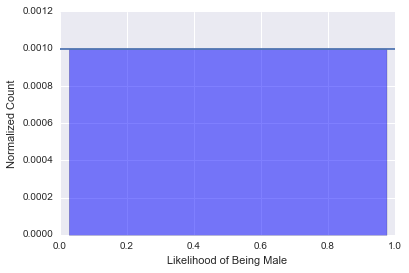

In [12]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')

cl = 0.95
m = 0
f = 0
x = np.linspace(0, 1, 1001)
y = beta.pdf(x, m + 1, f + 1) / (len(x) - 1)

cl_mask = ((x >= (beta.ppf((1 - cl) / 2, m + 1, f + 1))) & 
           (x <= (beta.ppf(1 - (1 - cl) / 2, m + 1, f + 1))))
xl = x[cl_mask]
yl = y[cl_mask]
print('95% c.l. lower bound: {}'.format(np.round(min(xl), 3)))
print('95% c.l. upper bound: {}'.format(np.round(max(xl), 3)))

# Boring, standard plots using matplotlib
fig, ax = plt.subplots()
plt.plot(x, y)
ax.fill_between(xl, 0, yl, facecolor='blue', alpha=0.5)
ax.set_ylabel('Normalized Count')
ax.set_xlabel('Likelihood of Being Male')
ax.set_ylim([0, max(y) * 1.2])
plt.show()

In [9]:
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.offline as py
init_notebook_mode(connected=True)
import plotly.graph_objs as pgo

# Pretty d3.js plots using Plotly
pylist = []
pylist.append(pgo.Scatter(x=xl,
                          y=yl,
                          mode='lines',
                          name='95% c.l.',
                          line=pgo.Line(color='rgba(1, 53, 51, 1)'),
                          fill='tonexty'))
pylist.append(pgo.Scatter(x=x,
                          y=y,
                          mode='lines',
                          showlegend=False,
                          line=pgo.Line(color='rgba(1, 53, 51, 1)')))

pydata = pgo.Data(pylist)
layout = pgo.Layout(
    xaxis=pgo.XAxis(title='Likelihood of Being Male',
                    range=[0, 1]),
    yaxis=pgo.YAxis(title='Normalized Count',
                    range=[0, max(y) * 1.2]),
    height=350, width=575,
    margin=pgo.Margin(t=50)
)
fig = pgo.Figure(data=pydata, layout=layout)
py.iplot(fig)

That'd be annoying to keep copying/pasting. Let's write a function!

In [22]:
def get_plot(m, f, cl=0.95, plot='plotly'):
    """
    Get a Plotly Figure object for a beta distribution
    with given parameters m and f.
    Also display the cl condidence bands.
    """
    x = np.linspace(0, 1, 1001)
    y = beta.pdf(x, m + 1, f + 1) / (len(x) - 1)

    cl_mask = ((x >= (beta.ppf((1 - cl) / 2, m + 1, f + 1))) & 
               (x <= (beta.ppf(1 - (1 - cl) / 2, m + 1, f + 1))))
    xl = x[cl_mask]
    yl = y[cl_mask]
    print('95% c.l. lower bound: {}'.format(np.round(min(xl), 3)))
    print('95% c.l. upper bound: {}'.format(np.round(max(xl), 3)))
    
    if plot == 'plotly':
        pylist = []
        pylist.append(pgo.Scatter(x=xl,
                                  y=yl,
                                  mode='lines',
                                  name='95% c.l.',
                                  line=pgo.Line(color='rgba(1, 53, 51, 1)'),
                                  fill='tonexty'))
        pylist.append(pgo.Scatter(x=x,
                                  y=y,
                                  mode='lines',
                                  showlegend=False,
                                  line=pgo.Line(color='rgba(1, 53, 51, 1)')))

        pydata = pgo.Data(pylist)
        layout = pgo.Layout(
            xaxis=pgo.XAxis(title='Likelihood of Being Male',
                            range=[0, 1]),
            yaxis=pgo.YAxis(title='Normalized Count',
                            range=[0, max(y) * 1.2]),
            height=350, width=575,
            margin=pgo.Margin(t=50)
        )
        fig = pgo.Figure(data=pydata, layout=layout)
        py.iplot(fig)
        return fig
    
    elif plot == 'matplotlib':
        fig, ax = plt.subplots()
        plt.plot(x, y)
        ax.fill_between(xl, 0, yl, facecolor='blue', alpha=0.5)
        ax.set_ylabel('Normalized Count')
        ax.set_xlabel('Likelihood of Being Male')
        ax.set_ylim([0, max(y) * 1.2])
        fig
        return fig
    
    else:
        raise ValueError('plot == ¯\_(ツ)_/¯')

In [34]:
# Set the last variable to either 'plotly' or 'matplotlib'
fig = get_plot(1, 0, 0.95, 'plotly')

95% c.l. lower bound: 0.159
95% c.l. upper bound: 0.987


Of course, we don't want the plot. That's just pretty. We want the lower and upper bounds. So, let's right a function for that, given m and f observations.

I'm going to make use of pandas here because I'll be using it in a bit.

In [4]:
import pandas as pd

def get_cl_bounds(m, f, cl=0.95):
    """
    Determine cl confidence bands on p (probablity that user is male) 
    given observations of m and f (numbers of male and female observed).
    """
    # x to resolution 0.001
    x = np.linspace(0, 1, 1001)
    # normalized beta distribution given m and f
    y = beta.pdf(x, m + 1, f + 1) / (len(x) - 1)
    # cut off values below quantile (1 - cl) / 2 (= 0.025 for 95% c.l.)
    # and above quantile 1 - (1 - cl) / 2 (= 0.975 for 95% c.l.) 
    cl_mask = ((x >= (beta.ppf((1 - cl) / 2, m + 1, f + 1))) & 
               (x <= (beta.ppf(1 - (1 - cl) / 2, m + 1, f + 1))))
    xl = x[cl_mask]
    # protect against having enough data that resolution isn't small enough
    # then, return the min and max value of the masked x are the bounds desired
    if len(xl) == 0:
        z = np.round(np.mean((beta.ppf((1 - cl) / 2, m + 1, f + 1), 
                              beta.ppf(1 - (1 - cl) / 2, m + 1, f + 1))), 3)
        return pd.Series({'lower': z, 'upper': z})
    else:
        return pd.Series({'lower': min(xl), 'upper': max(xl)})

get_cl_bounds(1, 0)

lower    0.159
upper    0.987
dtype: float64

So, if I had a dataframe like this:

In [5]:
df = pd.DataFrame({'name': ['Drew'], 'm': [1], 'f': [0]}).set_index('name')
df

,f,m
name,,
Drew,0,1


I could quickly apply this function to it to get the bounds.

In [6]:
df[['lower', 'upper']] = df.apply(lambda x: get_cl_bounds(x['m'], x['f']), axis=1)
df

,f,m,lower,upper
name,,,,
Drew,0,1,0.159,0.987


And this apply function would work the same with multiple rows at once.

In [7]:
df = (pd.DataFrame({'name': ['Drew', 'Alexis'], 
                    'm': [1, 0], 
                    'f': [0, 1]})
        .set_index('name'))
df[['lower', 'upper']] = df.apply(lambda x: get_cl_bounds(x['m'], x['f']), axis=1)
df

,f,m,lower,upper
name,,,,
Drew,0,1,0.159,0.987
Alexis,1,0,0.013,0.841


Now, to come up with a data set in this form.

I know! Let's check with the Social Security Administration!

# Retrieve name/sex data from the SSA

In [8]:
from zipfile import ZipFile
import sys
# Make this play nicely with both Python 2 and Python 3
if sys.version_info[0] == 2:
    from urllib import urlopen
    from StringIO import StringIO as myio
elif sys.version_info[0] == 3:
    from urllib.request import urlopen
    from io import BytesIO as myio

# Get the zip file from SSA
url = 'http://www.ssa.gov/oact/babynames/names.zip'
response = urlopen(url)
# Unzip the contents of the zip file
contents = ZipFile(myio(response.read()))
# Tell me the name of the files inside
for filename in contents.namelist():
    print(filename)


yob1881.txt
yob1882.txt
yob1883.txt
yob1884.txt
yob1885.txt
yob1886.txt
yob1887.txt
yob1888.txt
yob1889.txt
yob1890.txt
yob1891.txt
yob1892.txt
yob1893.txt
yob1894.txt
yob1895.txt
yob1896.txt
yob1897.txt
yob1898.txt
yob1899.txt
yob1900.txt
yob1901.txt
yob1902.txt
yob1903.txt
yob1904.txt
yob1905.txt
yob1906.txt
yob1907.txt
yob1908.txt
yob1909.txt
yob1910.txt
yob1911.txt
yob1912.txt
yob1913.txt
yob1914.txt
yob1915.txt
yob1916.txt
yob1917.txt
yob1918.txt
yob1919.txt
yob1920.txt
yob1921.txt
yob1922.txt
yob1923.txt
yob1924.txt
yob1925.txt
yob1926.txt
yob1927.txt
yob1928.txt
yob1929.txt
yob1930.txt
yob1931.txt
yob1932.txt
yob1933.txt
yob1934.txt
yob1935.txt
yob1936.txt
yob1937.txt
yob1938.txt
yob1939.txt
yob1940.txt
yob1941.txt
yob1942.txt
yob1943.txt
yob1944.txt
yob1945.txt
yob1946.txt
yob1947.txt
yob1948.txt
yob1949.txt
yob1950.txt
yob1951.txt
yob1952.txt
yob1953.txt
yob1954.txt
yob1955.txt
yob1956.txt
yob1957.txt
yob1958.txt
yob1959.txt
yob1960.txt
yob1961.txt
yob1962.txt
yob1963.txt
yob1

Parse through these files and retrieve the data from each if you want it.

In [9]:
import pandas as pd

# Get data from years in a list only, ignore the rest
years = ('1982', '1987', '1992')
data_files = []
for filename in contents.namelist():
    if filename[3:7] in years:
        data_files.append(filename)

# Read the desired csv data into a list of dataframes, then concat these together
df_list = [pd.read_csv(contents.open(data), 
                       names=['name', 'sex', 'count']) 
           for data in data_files]
df = pd.concat(df_list) 
df

,name,sex,count
0,Jennifer,F,57109
1,Jessica,F,45445
2,Amanda,F,34210
3,Sarah,F,28482
4,Melissa,F,25860
5,Nicole,F,21703
6,Stephanie,F,20858
7,Elizabeth,F,20509
8,Crystal,F,19101
9,Amy,F,18801


In [10]:
df.loc[(df['name'] == 'Drew')]

,name,sex,count
2595,Drew,F,36
12551,Drew,M,1015
1364,Drew,F,100
13411,Drew,M,1758
1328,Drew,F,126
15789,Drew,M,1779


Potentially multiple copies, up to one name/sex pair per year of data.

Have to do some grouping and aggregating.

In [11]:
df = df.groupby(['name', 'sex']).sum()
df

,,count
name,sex,
Aadam,M,5
Aadil,M,7
Aaisha,F,5
Aakash,M,55
Aaliyah,F,67
Aamer,M,5
Aamina,F,6
Aamir,M,46
Aapri,F,5


How about with M and F as the columns?

In [12]:
df.unstack(level='sex')

count         
sex               F        M
name                        
Aadam           NaN      5.0
Aadil           NaN      7.0
Aaisha          5.0      NaN
Aakash          NaN     55.0
Aaliyah        67.0      NaN
Aamer           NaN      5.0
Aamina          6.0      NaN
Aamir           NaN     46.0
Aapri           5.0      NaN
Aaran           NaN      6.0
Aaren          47.0     38.0
Aaric           NaN     23.0
Aarica         20.0      NaN
Aariel          9.0      NaN
Aarika        108.0      NaN
Aarin          26.0     29.0
Aarion          7.0     18.0
Aarn            NaN      5.0
Aaron         386.0  41595.0
Aaronda         5.0      NaN
Aaronjames      NaN      5.0
Aaronlee        NaN      5.0
Aaronmichael    NaN     19.0
Aarron          NaN    116.0
Aarthi          7.0      NaN
Aarti          43.0      NaN
Aaryn          47.0     23.0
Aasha           7.0      NaN
Aashish         NaN      6.0
Aasia           5.0      NaN
...             ...      ...
Zoraida        98.0      NaN
Zoran           NaN      9.0
Zoraya          6.0      NaN
Zorina          5.0      NaN
Zoua           30.0      NaN
Zowie           6.0      NaN
Zoya           36.0      NaN
Zoyla           5.0      NaN
Zsazsa         13.0      NaN
Zubair          NaN     33.0
Zubin           NaN     15.0
Zuhair          NaN      5.0
Zulay          25.0      NaN
Zuleica        18.0      NaN
Zuleika        80.0      NaN
Zuleima        49.0      NaN
Zulema        153.0      NaN
Zuleyka        38.0      NaN
Zuleyma        43.0      NaN
Zully          37.0      NaN
Zulma          86.0      NaN
Zuly           14.0      NaN
Zunilda         6.0      NaN
Zuri          103.0     15.0
Zuriel          NaN     17.0
Zury           11.0      NaN
Zvi             NaN     30.0
Zyair           NaN      5.0
Zyanya          8.0      NaN
Zykeia          5.0      NaN

[29633 rows x 2 columns]

Get rid of that superfluous count header. Oh, and fill those NaN's with 0.

In [13]:
df.unstack(level='sex')['count'].fillna(0)

sex,F,M
name,,
Aadam,0.0,5.0
Aadil,0.0,7.0
Aaisha,5.0,0.0
Aakash,0.0,55.0
Aaliyah,67.0,0.0
Aamer,0.0,5.0
Aamina,6.0,0.0
Aamir,0.0,46.0
Aapri,5.0,0.0


Bad practices above:
- Saved superfluous df_list to disk (taking up space)
- Wrote duped dataframe to the variable df
- Indices on df were nothing special, just integers (not even UNIQUE integers because of concat without ignore_index=True)
- Saved over variable df containing duped dataframe with the grouped version of it

Best to pipe together multiple commands. Piping in pandas is 😘👌.

# Condensed data retrieval from SSA

In [14]:
import pandas as pd
from zipfile import ZipFile
import sys
# Make this play nicely with both Python 2 and Python 3
if sys.version_info[0] == 2:
    from urllib import urlopen
    from StringIO import StringIO as myio
elif sys.version_info[0] == 3:
    from urllib.request import urlopen
    from io import BytesIO as myio

# Get the zip file from SSA
url = 'http://www.ssa.gov/oact/babynames/names.zip'
response = urlopen(url)
# Unzip the contents of the zip file
contents = ZipFile(myio(response.read()))
# Get data from years in a list only, ignore the rest
years = ('2013', '2014', '2015')
data_files = []
for filename in contents.namelist():
    if filename[3:7] in years:
        data_files.append(filename)

# Read the desired csv data into a list of dataframes, 
# then concat these together, 
# then group the name/sex pairs
df = (pd.concat([pd.read_csv(contents.open(data), 
                             names=['name', 'sex', 'count']) 
                 for data in data_files])
        .groupby(['name', 'sex']).sum()
        .unstack(level='sex')['count']
        .fillna(0)
      )
df

sex,F,M
name,,
Aaban,0.0,45.0
Aabha,16.0,0.0
Aabriella,10.0,0.0
Aada,5.0,0.0
Aadam,0.0,57.0
Aadan,0.0,31.0
Aadarsh,0.0,45.0
Aaden,0.0,736.0
Aadhav,0.0,80.0


In [15]:
df.loc[['Drew', 'Alexis']]

sex,F,M
name,,
Drew,645.0,3117.0
Alexis,12372.0,3353.0


Now, apply that function we wrote earlier.

In [16]:
df[['lower', 'upper']] = df.apply(lambda x: get_cl_bounds(x['M'], x['F']), axis=1)
df

sex,F,M,lower,upper
name,,,,
Aaban,0.0,45.0,0.923,0.999
Aabha,16.0,0.0,0.002,0.195
Aabriella,10.0,0.0,0.003,0.284
Aada,5.0,0.0,0.005,0.459
Aadam,0.0,57.0,0.939,0.999
Aadan,0.0,31.0,0.892,0.999
Aadarsh,0.0,45.0,0.923,0.999
Aaden,0.0,736.0,0.996,0.999
Aadhav,0.0,80.0,0.956,0.999


In [23]:
df.loc[['Drew', 'Alexis', 'Matthew', 'Jennifer']]

sex,F,M,lower,upper
name,,,,
Drew,645.0,3117.0,0.817,0.840
Alexis,12372.0,3353.0,0.207,0.219
Matthew,46.0,38818.0,0.999,0.999
Jennifer,4481.0,6.0,0.001,0.002
